# Disentangled VAE on MNIST


https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys 
import pandas as pd 
import numpy as np
import mlxtend

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

## Data import 

In [3]:
from mlxtend.data import mnist_data, loadlocal_mnist

### Demo subset

In [4]:
X, y = mnist_data()
X.shape, y.shape

((5000, 784), (5000,))

### Full dataset (local)

In [5]:
X, y = loadlocal_mnist(
        images_path='/home/genyrosk/datasets/mnist/train-images-idx3-ubyte', 
        labels_path='/home/genyrosk/datasets/mnist/train-labels-idx1-ubyte')

X_test, y_test = loadlocal_mnist(
        images_path='/home/genyrosk/datasets/mnist/t10k-images-idx3-ubyte', 
        labels_path='/home/genyrosk/datasets/mnist/t10k-labels-idx1-ubyte')

X.shape, y.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [6]:
X[0].reshape(28,28).shape

(28, 28)

0


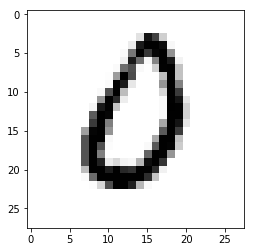

In [7]:
img_idx = 666
print(y[img_idx])
plt.imshow(X[img_idx].reshape(28,28), cmap='Greys')

### The pytorch way

In [16]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            '../data', 
            train=True, 
            download=True,
            transform=transforms.ToTensor()
        ),
        batch_size=batch_size, 
        shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            '../data', 
            train=False, 
            transform=transforms.ToTensor()
        ),
        batch_size=batch_size, 
        shuffle=True)

torch.Size([64, 1, 28, 28])


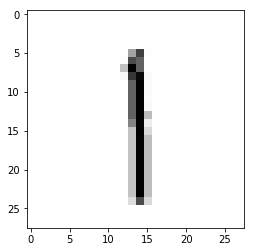

In [17]:
for idx, (x, _) in enumerate(train_loader):
    print(x.shape)
    plt.imshow(x[0,0,:,:], cmap='Greys')
#     print(x[0].shape)
#     print(x[1].shape)
    break

## Model

In [29]:
class VAE(nn.Module):
    
    def __init__(self, z_dim=20):
        super(VAE, self).__init__()
        # encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, z_dim)
        self.fc22 = nn.Linear(400, z_dim)
        # decoder
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
    
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        print(x.shape)
        sys.exit()
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [30]:
log_interval = 10
epochs = 10

device = torch.device("cuda")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')

torch.Size([64, 1, 28, 28])


SystemExit: 

/home/genyrosk/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<br/>
<br/>
<br/>

# Convolutional approach 

http://cs231n.github.io/convolutional-networks/ : 

> **Getting rid of pooling**. Many people dislike the pooling operation and think that we can get away without it. For example, Striving for Simplicity: The All Convolutional Net proposes to discard the pooling layer in favor of architecture that only consists of repeated CONV layers. To reduce the size of the representation they suggest using larger stride in CONV layer once in a while. Discarding pooling layers has also been found to be important in training good generative models, such as variational autoencoders (VAEs) or generative adversarial networks (GANs). It seems likely that future architectures will feature very few to no pooling layers.


Conv layer output:

W_out = (W_in - Kernel + 2*Padding) / Stride + 1


Tranposed Conv layer output (typically, dilation=1): 

W_out = (W_in - 1)×Stride + Dilation×(Kernel - 1) - 2×Padding + 1

<br/>
<br/>

## 1. Convolutions + Transposed Convolutions

In [123]:
x = torch.ones([64,1,28,28])
print('x:', x.shape)

img_channels = 1
conv1 = nn.Sequential(
    nn.Conv2d(img_channels, 10, kernel_size=3, stride=1, padding=1),
    nn.ReLU()
)
x = conv1(x)
print('x:', x.shape)

conv2 = nn.Sequential(
    nn.Conv2d(10, 10, kernel_size=4, stride=2, padding=1),
    nn.ReLU()
)
x = conv2(x)
print('x:', x.shape)

conv3 = nn.Sequential(
    nn.Conv2d(10, 20, kernel_size=5, stride=2, padding=2),
    nn.ReLU()
)
x = conv3(x)
print('x:', x.shape)

conv4 = nn.Sequential(
    nn.Conv2d(20, 20, kernel_size=5, stride=1, padding=2),
    nn.ReLU()
)
x = conv4(x)
print('x:', x.shape)

x = Flatten()(x)
print('x:', x.shape)

h_dim = x.shape[1]
z_dim = 20
fc11 = nn.Linear(h_dim, z_dim)
x = fc11(x)
print('x:', x.shape)

## decoder
fc2 = nn.Linear(z_dim, h_dim)
x = fc2(x)
print('x:', x.shape)

# x.view(x.size(0), 30, 5, 5).shape
x = UnFlatten()(x)
print('x:', x.shape)

deconv1 = nn.Sequential(
#     UnFlatten(),
    nn.ConvTranspose2d(20, 10, kernel_size=4, stride=2, padding=1),
    nn.ReLU(),
)
x = deconv1(x)
print('x:', x.shape)

deconv2 = nn.Sequential(
    nn.ConvTranspose2d(10, 10, kernel_size=5, stride=2, padding=2),
    nn.ReLU(),
)
x = deconv2(x)
print('x:', x.shape)

deconv3 = nn.Sequential(
    nn.ConvTranspose2d(10, 10, kernel_size=6, stride=1, padding=2),
    nn.Sigmoid(),
)
x = deconv3(x)
print('x:', x.shape)

deconv4 = nn.Sequential(
    nn.ConvTranspose2d(10, 1, kernel_size=5, stride=1, padding=2),
    nn.Sigmoid(),
)
x = deconv4(x)
print('x:', x.shape)

x: torch.Size([64, 1, 28, 28])
x: torch.Size([64, 10, 28, 28])
x: torch.Size([64, 10, 14, 14])
x: torch.Size([64, 20, 7, 7])
x: torch.Size([64, 20, 7, 7])
x: torch.Size([64, 980])
x: torch.Size([64, 20])
x: torch.Size([64, 980])
x: torch.Size([64, 20, 7, 7])
x: torch.Size([64, 10, 14, 14])
x: torch.Size([64, 10, 27, 27])
x: torch.Size([64, 10, 28, 28])
x: torch.Size([64, 1, 28, 28])


<br/>
<br/>

## 2. Convolutions + Upsampling Convolutions

In [124]:
x = torch.ones([64,1,28,28])
print('x:', x.shape)

img_channels = 1
conv1 = nn.Sequential(
    nn.Conv2d(img_channels, 10, kernel_size=3, stride=1, padding=1),
    nn.ReLU()
)
x = conv1(x)
print('x:', x.shape)

conv2 = nn.Sequential(
    nn.Conv2d(10, 10, kernel_size=4, stride=2, padding=1),
    nn.ReLU()
)
x = conv2(x)
print('x:', x.shape)

conv3 = nn.Sequential(
    nn.Conv2d(10, 20, kernel_size=5, stride=2, padding=2),
    nn.ReLU()
)
x = conv3(x)
print('x:', x.shape)

x = Flatten()(x)
print('x:', x.shape)

h_dim = x.shape[1]
z_dim = 20
fc11 = nn.Linear(h_dim, z_dim)
x = fc11(x)
print('x:', x.shape)

## decoder
fc2 = nn.Linear(z_dim, h_dim)
x = fc2(x)
print('x:', x.shape)

# x.view(x.size(0), 30, 5, 5).shape
x = UnFlatten()(x)
print('x:', x.shape)

x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
print('x:', x.shape)
deconv1 = nn.Sequential(
    nn.Conv2d(20, 10, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
)
x = deconv1(x)
print('x:', x.shape)

x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
print('x:', x.shape)
deconv2 = nn.Sequential(
    nn.Conv2d(10, 10, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
)
x = deconv2(x)
print('x:', x.shape)

deconv3 = nn.Sequential(
    nn.Conv2d(10, 1, kernel_size=5, stride=1, padding=2),
    nn.Sigmoid(),
)
x = deconv3(x)
print('x:', x.shape)

x: torch.Size([64, 1, 28, 28])
x: torch.Size([64, 10, 28, 28])
x: torch.Size([64, 10, 14, 14])
x: torch.Size([64, 20, 7, 7])
x: torch.Size([64, 980])
x: torch.Size([64, 20])
x: torch.Size([64, 980])
x: torch.Size([64, 20, 7, 7])
x: torch.Size([64, 20, 14, 14])
x: torch.Size([64, 10, 14, 14])
x: torch.Size([64, 10, 28, 28])
x: torch.Size([64, 10, 28, 28])
x: torch.Size([64, 1, 28, 28])


## Generate layers parametrically 

In [78]:
def conv_output_dim(input_size, padding, kernel_size, stride, **kwargs):
    from math import floor
    return floor((input_size + 2*padding - kernel_size)/stride + 1)

def conv_transpose_output_dim(input_size, padding, kernel_size, stride, dilation=1, **kwargs):
    from math import floor
    return floor((input_size-1)*stride - 2*padding + d*(kernel_size-1) + 1)

def convnet_to_dense_size(input_size, params_list):
    size = input_size
    for params in params_list:
        size = conv_output_dim(size, **params)
    return size * size * params_list[-1]['out_channels']

def conv_net_layers(input_channels, params_list):
    layers = []
    for i in range(len(params_list)):
        if i == 0:
            in_channels = input_channels
        else:
            in_channels = params_list[i-1]['out_channels']
                
        layers += [
            nn.Conv2d(in_channels, **params_list[i]),
            nn.ReLU()
        ]
        
    return layers


params_list = [
    dict(out_channels=10, kernel_size=3, stride=1, padding=1), 
    dict(out_channels=10, kernel_size=4, stride=2, padding=1), 
    dict(out_channels=20, kernel_size=5, stride=2, padding=2)
]

conv_net_layers(1, params_list)

[Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 Conv2d(10, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
 ReLU()]

In [51]:
convnet_to_dense_size(28, params_list)

980

In [55]:
print(X.reshape(X.shape[0], 1, 28,28)[0].shape)
print(X[0].reshape(28,28).shape)

(1, 28, 28)
(28, 28)


<IPython.core.display.Javascript object>


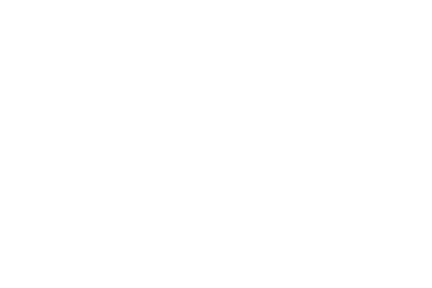

<IPython.core.display.Javascript object>


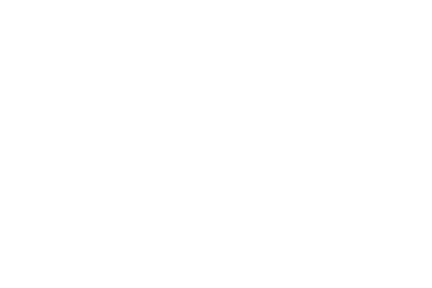

In [56]:
plt.imshow(X.reshape(X.shape[0], 1, 28,28)[0,0], cmap='Greys')

In [137]:
up = F.interpolate(x, scale_factor=(2,2), mode='nearest')
up.shape

torch.Size([1, 30, 10, 10])

<br/>
<br/>

## Datasets

In [30]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            '../data', 
            train=True, 
            download=True,
            transform=transforms.ToTensor()
        ),
        batch_size=batch_size, 
        shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            '../data', 
            train=False, 
            transform=transforms.Compose([
                transforms.Resize(28),
                transforms.ToTensor(), 
            ])
        ),
        batch_size=batch_size, 
        shuffle=True)

In [79]:
def conv_output_dim(input_size, kernel_size, stride=1, padding=0, **kwargs):
    from math import floor
    return floor((input_size + 2*padding - (kernel_size - 1) - 1)/stride + 1)

def conv_transpose_output_dim(input_size, kernel_size, stride=1, padding=0, dilation=1, **kwargs):
    return (input_size-1)*stride - 2*padding + dilation*(kernel_size-1) + 1

# (H −1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1

## encoder
input_size = 28
conv1_kwargs = dict(out_channels=10, kernel_size=3, stride=1, padding=1)
a1_size = conv_output_dim(input_size, **conv1_kwargs)

conv2_kwargs = dict(out_channels=10, kernel_size=4, stride=2, padding=1)
a2_size = conv_output_dim(a1_size, **conv2_kwargs)

conv3_kwargs = dict(out_channels=20, kernel_size=5, stride=2, padding=2)
a3_size = conv_output_dim(a2_size, **conv2_kwargs)

h_dim = a3_size**2 * conv3_filters
print(a3_size)
print(h_dim)

## decoder 
deconv1_filters = 10
deconv1_kwargs = dict(kernel_size=5, stride=2, padding=2)
d1_size = conv_transpose_output_dim(a3_size, **deconv1_kwargs)

deconv2_filters = 10
deconv2_kwargs = dict(kernel_size=5, stride=2, padding=1)
d2_size = conv_transpose_output_dim(d1_size, **deconv2_kwargs)

deconv3_filters = 20
deconv3_kwargs = dict(kernel_size=6, stride=1, padding=2)
d3_size = conv_transpose_output_dim(d2_size, **deconv3_kwargs)

print(d1_size, d2_size, d3_size)

7
980
13 27 28


In [34]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 20, 7, 7)
    
class VAE_conv(nn.Module):
    
    def __init__(self, z_dim=20, img_channels=1, h_dim=980):
        super(VAE_conv, self).__init__()
        # in = 1x28x28
        ## encoder 
        self.conv1 = nn.Sequential(
            nn.Conv2d(img_channels, **conv1_kwargs),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(conv1_filters, **conv2_kwargs),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(conv2_filters, **conv3_kwargs),
            nn.ReLU()
        )
        self.to_dense = Flatten()
        ## map to latent z
        self.fc11 = nn.Linear(h_dim, z_dim)
        self.fc12 = nn.Linear(h_dim, z_dim)

        ## decoder
        self.fc2 = nn.Linear(z_dim, h_dim)
        self.reshape = UnFlatten()
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(20, 10, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(10, 10, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(10, img_channels, kernel_size=6, stride=1, padding=2),
            nn.Sigmoid(),
        )
    
    def encode(self, x):
        a1 = self.conv1(x)
        a2 = self.conv2(a1)
        a3 = self.conv3(a2)
        h = self.to_dense(a3)
        return self.fc11(h), self.fc12(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = self.reshape(self.fc2(z))
        a1 = self.deconv1(h)
        a2 = self.deconv2(a1)
        a3 = self.deconv3(a2)
        return a3

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, beta=4.0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta * KLD

In [36]:
log_interval = 100
epochs = 10

device = torch.device("cuda")
model = VAE_conv().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


train_losses = []
test_losses = []

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        train_losses.append(loss.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item()
            test_losses.append(loss.item())
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results_disentangled/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results_disentangled/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 561.239563
Train Epoch: 1 [6400/60000 (11%)]	Loss: 218.082153
Train Epoch: 1 [12800/60000 (21%)]	Loss: 214.886307
Train Epoch: 1 [19200/60000 (32%)]	Loss: 197.013885
Train Epoch: 1 [25600/60000 (43%)]	Loss: 186.881088
Train Epoch: 1 [32000/60000 (53%)]	Loss: 176.642685
Train Epoch: 1 [38400/60000 (64%)]	Loss: 167.416183
Train Epoch: 1 [44800/60000 (75%)]	Loss: 163.468018
Train Epoch: 1 [51200/60000 (85%)]	Loss: 165.989944
Train Epoch: 1 [57600/60000 (96%)]	Loss: 159.502594
====> Epoch: 1 Average loss: 193.5362
====> Test set loss: 161.5780
Train Epoch: 2 [0/60000 (0%)]	Loss: 161.264465
Train Epoch: 2 [6400/60000 (11%)]	Loss: 163.652832
Train Epoch: 2 [12800/60000 (21%)]	Loss: 157.056152
Train Epoch: 2 [19200/60000 (32%)]	Loss: 157.840698
Train Epoch: 2 [25600/60000 (43%)]	Loss: 144.950607
Train Epoch: 2 [32000/60000 (53%)]	Loss: 171.751587
Train Epoch: 2 [38400/60000 (64%)]	Loss: 163.644073
Train Epoch: 2 [44800/60000 (75%)]	Loss: 162.428879
Train Ep

In [57]:
model.conv2[0].weight

Parameter containing:
tensor([[[[-2.5532e-02,  9.6189e-02, -5.6857e-02, -4.6945e-02],
          [ 3.4484e-02,  2.6785e-02, -3.3246e-02, -1.0215e-01],
          [ 5.9179e-02,  9.9631e-04, -3.8193e-02,  2.8421e-02],
          [ 7.5406e-02, -5.4936e-02,  1.6564e-02, -6.5869e-02]],

         [[-6.1550e-02, -2.2542e-02, -6.2990e-02, -6.3946e-02],
          [-5.1059e-03, -8.5668e-02, -5.7682e-02, -4.9221e-02],
          [-2.4784e-03, -5.1993e-02,  7.5899e-02,  5.7753e-02],
          [-2.3375e-02, -2.1766e-02,  1.5546e-02,  2.6573e-02]],

         [[ 1.0871e-02,  3.0679e-02,  4.4310e-02, -2.2218e-02],
          [ 1.2188e-01,  9.1088e-02,  2.0921e-02,  6.1734e-02],
          [ 3.4314e-02,  2.8205e-02,  5.3517e-02,  5.8479e-03],
          [-5.9018e-02, -2.8188e-02, -7.9458e-02,  1.1513e-02]],

         ...,

         [[-4.8093e-02,  3.7413e-02, -1.2795e-02, -2.0957e-02],
          [-4.9923e-03,  4.2781e-02,  4.3408e-02,  7.4226e-02],
          [ 2.4377e-02,  4.4817e-02,  6.4747e-02,  8.7377e-02

In [87]:
print(VAE_conv())

VAE_conv(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (to_dense): Flatten()
  (fc11): Linear(in_features=980, out_features=20, bias=True)
  (fc12): Linear(in_features=980, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=980, bias=True)
  (reshape): UnFlatten()
  (deconv1): Sequential(
    (0): ConvTranspose2d(20, 10, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(10, 10, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(10, 1, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
  )
)


torch.Size([64, 1, 28, 28])


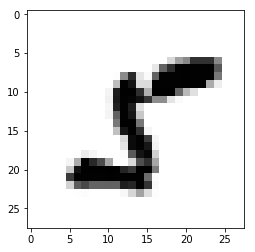

In [26]:
for idx, (x, _) in enumerate(train_loader):
    print(x.shape)
    plt.imshow(x[0,0,:,:], cmap='Greys')
#     print(x[0].shape)
#     print(x[1].shape)
    break

In [14]:
x = torch.ones([64, 20, 7, 7])
print(x.shape)
nn.PixelShuffle(upscale_factor=2)(x).shape

torch.Size([64, 20, 7, 7])


torch.Size([64, 5, 14, 14])

In [30]:
x = torch.ones([64,20])
## decoder
fc2 = nn.Linear(20, 1568)
x = fc2(x)
print('x:', x.shape)

x = x.view(64, 32, 7, 7)
print('x:', x.shape)

x = nn.PixelShuffle(upscale_factor=2)(x)
print('x:', x.shape)
deconv1 = nn.Sequential(
    nn.Conv2d(8, 32, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
)
x = deconv1(x)
print('x:', x.shape)

deconv2 = nn.Sequential(
    nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
)
x = deconv2(x)
print('x:', x.shape)

deconv3 = nn.Sequential(
    nn.Conv2d(32, 4, kernel_size=5, stride=1, padding=2),
    nn.Sigmoid(),
)
x = deconv3(x)
print('x:', x.shape)

x = nn.PixelShuffle(upscale_factor=2)(x)
print('x:', x.shape)

x: torch.Size([64, 1568])
x: torch.Size([64, 32, 7, 7])
x: torch.Size([64, 8, 14, 14])
x: torch.Size([64, 32, 14, 14])
x: torch.Size([64, 32, 14, 14])
x: torch.Size([64, 4, 14, 14])
x: torch.Size([64, 1, 28, 28])
